In [31]:
import time
import tensorflow.keras.backend as K
K.clear_session()

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping


from keras.datasets import cifar10

import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ReduceLROnPlateau


%matplotlib inline

%run sequential_model.ipynb import SequentialModel

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.metrics import Precision, Recall



Model: "cnn_sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,376,292 (16.69 MB)

 Trainable params: 4,376,292 (16.69 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Loading cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalizing pixel values
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# split tests and dataset classes
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=45)
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

print('The one hot label is:', y_train_one_hot[1])


The one hot label is: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [ ]:
K.clear_session()
%run sequential_model.ipynb import SeqModel

WITH_SGD = False
# force everywhere use 32/32 image pixel size
IMG_SIZE = (32, 32)
BATCH_SIZE = 32

# Data Augmentation
data_generator = ImageDataGenerator(
    rotation_range=15,         # Random rotation (max 15 degrees)
    width_shift_range=0.1,     # Shift image width by 10%
    height_shift_range=0.1,    # Shift image height by 10%
    horizontal_flip=True,      # Flip image horizontally
    zoom_range=0.2,            # Random zoom
    shear_range=0.2,           # Shear transformation
    fill_mode='nearest',       # Fill missing pixels
    validation_split=0.2       # Split data to 20% validation
)

# merge with main vector from datasource
data_generator.fit(x_train)

train_generator = data_generator.flow(
    x_train,
    y_train_one_hot,
    batch_size=BATCH_SIZE
)

# validator batch
val_generator = ImageDataGenerator(rescale=1./255).flow(
    x_val,
    y_val,
    batch_size=BATCH_SIZE
)

# Initialize models
model = SeqModel(num_classes=10).main()

'''
Callback Early stop based on val_accuracy
based on the amount of epochs before stpoing when no improvement
this will keep the model balanced to avoid overfiting
'''

class CustomEarlyStopping(EarlyStopping):
    def on_train_end(self, logs=None):
        print("\n🚀 Training stopped early due to no improvement in validation accuracy!")


early_stopping = CustomEarlyStopping(
    monitor='val_accuracy',  
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.01,
    patience=3,
    min_lr=1e-2
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.001,
    patience=2,
    min_lr=1e-5
)

#optimizer = SGD(learning_rate=0.0001, momentum=0.9)
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-3,
    amsgrad=False
)


# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', Precision(), Recall()]
)

start_time = time.time()
hist = model.fit(
    train_generator,
    validation_data=(x_test, y_test_one_hot),
    epochs=20,
    validation_steps=x_test.shape[0] // BATCH_SIZE,
    batch_size=BATCH_SIZE,
    callbacks=[lr_scheduler, reduce_lr, early_stopping]
)
# gathering elapsed time
elapsed_time = time.time() - start_time

# Train the model
print(f'Running fit/history for {model.name}')
histories = {
    'name': model.name,
    'hist': hist,
    'elapsed_time': elapsed_time
}

/Users/rondineli/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "cnn_sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,638,948 (17.70 MB)

 Trainable params: 4,638,948 (17.70 MB)

 Non-trainable params: 0 (0.00 B)

Model: "cnn_sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,592,778 (17.52 MB)

 Trainable params: 4,592,778 (17.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/Users/rondineli/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 40ms/step - accuracy: 0.2464 - loss: 2.1756 - precision: 0.4799 - recall: 0.0317 - val_accuracy: 0.4675 - val_loss: 1.4713 - val_precision: 0.6684 - val_recall: 0.2507 - learning_rate: 0.0010
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.4469 - loss: 1.5543 - precision: 0.6369 - recall: 0.2260 - val_accuracy: 0.5675 - val_loss: 1.2385 - val_precision: 0.7033 - val_recall: 0.4368 - learning_rate: 0.0010
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.5424 - loss: 1.3325 - precision: 0.7095 - recall: 0.3616 - val_accuracy: 0.6230 - val_loss: 1.0916 - val_precision: 0.7412 - val_recall: 0.5154 - learning_rate: 0.0010
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.5951 - loss: 1.1884 - precision: 0.7418 - recall: 0.4436 - val_accuracy: 0.6819 - val_loss: 0.9578 - val_precision: 0.7951 - val_recall: 0.5638 - learning_rate: 0.0010
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - a

{'name': 'cnn_sequential', 'hist': <keras.src.callbacks.history.History object at 0x31a808220>, 'elapsed_time': 1014.8361830711365}


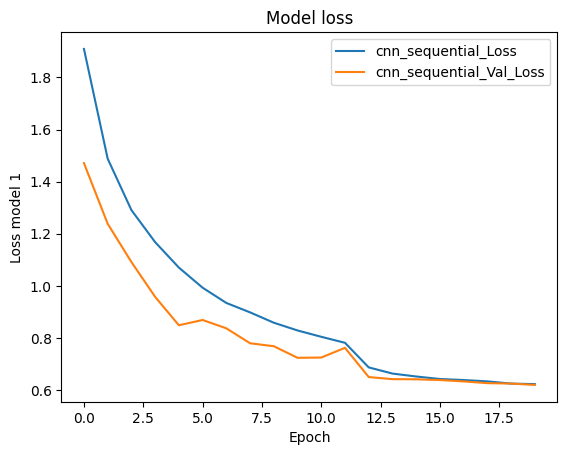

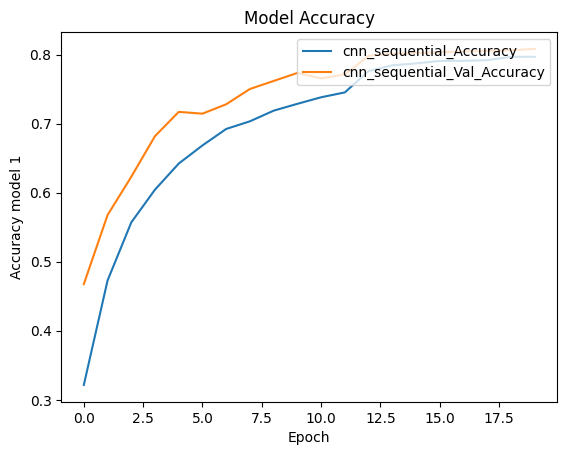

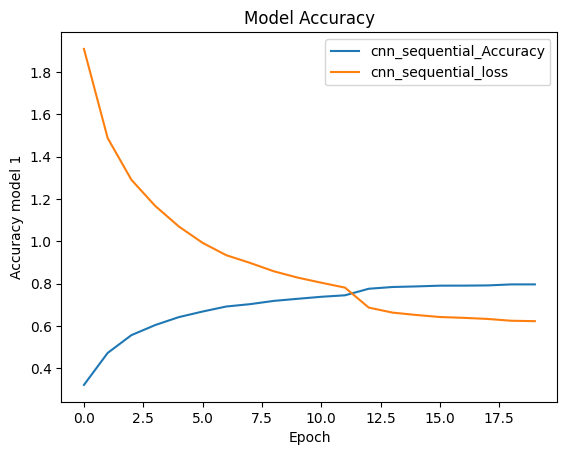

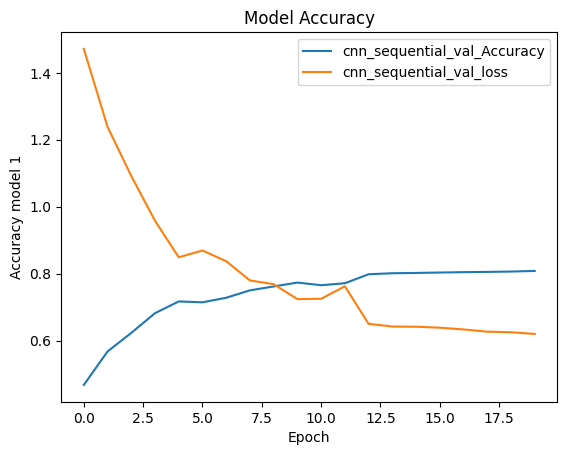

In [64]:
import matplotlib.pyplot as plt

leg = []

for h in histories:
    print(h)
    leg.append(f'{h["name"]}_Loss')
    leg.append(f'{h["name"]}_Val_Loss')
    plt.plot(h['hist'].history['loss'])
    plt.plot(h['hist'].history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss model 1')
plt.xlabel('Epoch')

plt.legend(leg, loc='upper right')
plt.savefig("400_epochs_loss.png", dpi=300)
plt.show()


#import matplotlib.pyplot as plt
#plt.plot(hist.history['accuracy'])
#plt.plot(hist.history['val_accuracy'])
#plt.title(f'Model Accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Val'], loc='upper right')
#plt.show()


leg = []
import matplotlib.pyplot as plt

for h in [histories[0]]:
    leg.append(f'{h["name"]}_Accuracy')
    leg.append(f'{h["name"]}_Val_Accuracy')
    plt.plot(h['hist'].history['accuracy'])
    plt.plot(h['hist'].history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy model 1')
plt.xlabel('Epoch')

plt.legend(leg, loc='upper right')
plt.savefig("400_epochs__wav_accuracy.png", dpi=300)
plt.show()

leg = []
import matplotlib.pyplot as plt

for h in [histories[0]]:
    leg.append(f'{h["name"]}_Accuracy')
    leg.append(f'{h["name"]}_loss')
    plt.plot(h['hist'].history['accuracy'])
    plt.plot(h['hist'].history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy model 1')
plt.xlabel('Epoch')
plt.legend(leg, loc='upper right')
plt.savefig("400_epochs__wav_loss.png", dpi=300)
plt.show()

leg = []
import matplotlib.pyplot as plt

for h in [histories[0]]:
    leg.append(f'{h["name"]}_val_Accuracy')
    leg.append(f'{h["name"]}_val_loss')
    plt.plot(h['hist'].history['val_accuracy'])
    plt.plot(h['hist'].history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy model 1')
plt.xlabel('Epoch')
plt.legend(leg, loc='upper right')
plt.savefig("400_epochs__wav_loss_acc.png", dpi=300)
plt.show()


In [65]:

for hist in histories:
    train_acc = hist['hist'].history['accuracy']
    val_acc = hist['hist'].history['val_accuracy']

    print(f"[{hist['name']}] Acc: {train_acc}")
    print(f"[{hist['name']}] Val_Acc: {val_acc}")

    train_improvement = ((train_acc[-1] - train_acc[0]) / train_acc[0]) * 100
    val_improvement = ((val_acc[-1] - val_acc[0]) / val_acc[0]) * 100

    print(f"[{hist['name']}] Training Accuracy Improvement: {train_improvement:.2f}%")
    print(f"[{hist['name']}] Validation Accuracy Improvement: {val_improvement:.2f}%")

[cnn_sequential] Acc: [0.32155001163482666, 0.4727500081062317, 0.5568749904632568, 0.6043999791145325, 0.6420750021934509, 0.66839998960495, 0.6922000050544739, 0.7032999992370605, 0.7186999917030334, 0.728600025177002, 0.738099992275238, 0.7451500296592712, 0.776075005531311, 0.7843250036239624, 0.7871249914169312, 0.7907000184059143, 0.7908750176429749, 0.7918000221252441, 0.7966499924659729, 0.7966750264167786]
[cnn_sequential] Val_Acc: [0.46754807233810425, 0.5675080418586731, 0.6229968070983887, 0.6818910241127014, 0.7169471383094788, 0.7143429517745972, 0.7279647588729858, 0.7501001358032227, 0.76171875, 0.7733373641967773, 0.7654246687889099, 0.7712339758872986, 0.7981770634651184, 0.8011819124221802, 0.8020833134651184, 0.8032852411270142, 0.8043870329856873, 0.8051882982254028, 0.8061898946762085, 0.8080929517745972]
[cnn_sequential] Training Accuracy Improvement: 147.76%
[cnn_sequential] Validation Accuracy Improvement: 72.84%


In [66]:
num_classes = 10
class_names = [str(i) for i in range(num_classes)]
print(class_names)
from sklearn.metrics import classification_report

# Get model predictions
y_pred_probs = model.predict(x_test)  
y_pred = y_pred_probs.argmax(axis=1)  # Convert probabilities to class indices

# Get true labels
y_true = y_test  # No need for .classes since it's already a NumPy array

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1000
           1       0.90      0.92      0.91      1000
           2       0.81      0.65      0.72      1000
           3       0.73      0.57      0.64      1000
           4       0.79      0.76      0.78      1000
           5       0.77      0.70      0.74      1000
           6       0.70      0.94      0.80      1000
           7       0.84      0.87      0.85      1000
           8       0.91      0.89      0.90      1000
           9       0.81      0.94      0.87      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.80     10000
weighted avg       0.81      0.81      0.80     10000



In [67]:
model.evaluate(x_test, y_test_one_hot)[1]

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8121 - loss: 0.6181 - precision: 0.8547 - recall: 0.7659


0.8080000281333923